# Option Pricing Models

This is an implementation of the 3 main option pricing models used to estimate the theoretical value of an **European** style option.

## Binomial Option Pricing Model:
In here we assume that markets are **perfectly efficient**, which allows the model to price the option at each point in a specified time frame.

This pricing model is designed for **European Call Options** so we price the option based on the following:

Stock tree can be represented using nodes $(i, j)$ and initial stock price $S0$

$$
S_{i,j} = S_0 u^j d^{i-j}
$$

$C_{i,j}$ represents contract price at each node $(i, j)$

$C_{N,j}$ represents final payoff function that we can define, where $N$ is the number of time steps


### Binomial Option Pricing Model Formulas
- **Risk-free probability `q`:**
  - Formula: $ q = \frac{e^{r \Delta t} - d}{u - d} $
  - Description: Calculates the risk-neutral probability of the price moving up in the binomial model.

- **Discounted payoff:**
  - Formula: $ e^{-r \Delta t} $
  - Description: Factor to discount the option payoff back to the present value.

- **Asset price at maturity:**
  - Formula: $ S_0 \times d^{(N-i)} \times u^{i} $ for $ i $ from 0 to N
  - Description: Calculates the possible asset prices at maturity using up and down factors over N periods.

- **Option value at maturity:**
  - Formula: $ \max(S_T - K, 0) $
  - Description: Calculates the payoff of a European call option at maturity, where $ S_T $ is the asset price at maturity.


In [41]:
# import dependencies
import numpy as np

# initial derivative parameters
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # arbitrary annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # down-factor (NOTE: d must be 1/u, otherwise the binomial tree structure will break)

def binomial_pricing_model(K,T,S0,r,N,u,d):
    #precompute constants
    dt = T/N 
    q = (np.exp(r*dt) - d) / (u-d) # the risk-free probability
    disc = np.exp(-r*dt) # the discounted payoff

    # initialise asset prices at maturity - Time step N
    C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1))

    # initialise option values at maturity
    C = np.maximum( C - K , np.zeros(N+1) )

    # step backwards through tree
    for i in np.arange(N,0,-1):
        C = disc * ( q * C[1:i+1] + (1-q) * C[0:i] ) # C[1:i+1] is the up-vector and C[0:i] is the down-vector

    return C[0]

val = binomial_pricing_model(K,T,S0,r,N,u,d)
print(f"European Call Option Value: {val:.2f} AED")

European Call Option Value: 10.15 AED


## Black-Scholes Model
In here we make the following assumptions about the stock price distribution:
1. Continuously compounded returns on the stock are normally distributed and independent over time.
2. The volatility of continuously compounded returns is known and constant.
3. Future dividends are known

We also make the following assumption about the economic environment:
1. The risk-free rate is known and constant.
2. There are no transaction costs or taxes.
3. It is possible to short-sell with no cost and to borrow at the risk-free rate.

The pricing model is designed to price **European Style Calls/Puts**



### Black-Scholes Model Formulas
- **$ d1 $ and $ d2 $ calculations:**
  - Formula: 
    - $ d1 = \frac{\log(S/K) + (r + \sigma^2/2) \times T}{\sigma \times \sqrt{T}} $
    - $ d2 = d1 - \sigma \times \sqrt{T} $
  - Description: These are intermediary steps in calculating the call and put option prices.

- **Call option price (`C`):**
  - Formula: $ C = S \times \Phi(d1) - K \times e^{-rT} \times \Phi(d2) $
  - Description: Calculates the price of a European call option using the cumulative distribution function $ \Phi $ of the standard normal distribution.

- **Put option price (`P`):**
  - Formula: $ P = K \times e^{-rT} \times \Phi(-d2) - S \times \Phi(-d1) $
  - Description: Calculates the price of a European put option.

In [42]:
from scipy.stats import norm

# initial derivative parameters
r = 0.01 # arbitrary annual risk-free rate
S = 20 # underlying stock price
K = 40 # strike price
T = 0.5 # time to maturity/expiration in years
sigma = 30 # measure of volatility

def blackScholes(r, S, K, T, sigma, type='c'):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")


cVal = blackScholes(r, S, K, T, sigma, type='c')
pVal = blackScholes(r, S, K, T, sigma, type='p')

print(f"Price of call option: {cVal:.2f} AED")
print(f"Price of put option: {pVal:.2f} AED")


Price of call option: 20.00 AED
Price of put option: 39.80 AED


## Monte-Carlo Simulation based on a Geometric Brownian Motion (GBM) model
In here we make the following assumptions:
1. Pricing is risk-neutral 
2. Stock price follows a random walk (meaning that the change in stock price overtime is random and cannot be predicted using past patterns and/or technical analysis)
3. Stock price reflects the true, fair value of the stock (meaning that investors cannot buy undervalued assets or sell overvalued assets in the market), also known as the Efficient Market Hypothesis (EMH)
 

### Monte Carlo Simulation Formulas
- **Simulation of final stock prices $S_T$:**
  - Formula: $ S_T = S_0 \times e^{(r - \frac{\sigma^2}{2})T + \sigma \times \sqrt{T} \times Z} $
  - Description: Simulates the possible future stock price at maturity, where $ Z $ is a standard normal variable.

- **Call option payoff:**
  - Formula: $ \max(S_T - K, 0) $
  - Description: Represents the payoff of a call option, which is the positive part of the difference between the stock price at maturity and the strike price.

- **Discounted expected payoff:**
  - Formula: $ e^{-rT} \times \frac{1}{M} \sum \max(S_T - K, 0) $
  - Description: The expected payoff of the option is averaged over many simulated paths and discounted to present value.

- **Standard error of estimate:**
  - Formula: $ \sigma/\sqrt{M} $
  - Description: Calculates the standard error of the Monte Carlo estimate to gauge the accuracy of the simulation.


In [43]:
# import dependencies
import numpy as np

# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #arbitrary implied volatility (%) 
r = 0.01            #arbitrary risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option

T = 0.5    #time to maturity/expiration in years

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt) # the simulated stock prices at each time step
CT = np.maximum(0, ST - K) # the payoff of the call option at maturity (max(ST - K, 0))
C0 = np.exp(-r*T)*np.sum(CT[-1])/M  # the present value of the expected payoff of the call option

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) ) #standard deviation of the simulated payoffs
SE = sigma/np.sqrt(M) #standard error of the estimated option price

print("Call value is {0} AED with standard error +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is 5.11 AED with standard error +/- 0.18


## Using Antithetic Variates
Although the above implementation is a great method for approximating option values with complex payoffs or high dimensionality, in order to get an acceptably accurate estimate we must perform a large number of simulations. Instead we can lean on **variance reduction methods** which help make Monte Carlo models more efficient, by improving the precision of the model without increasing the computation cost.

One commonly used variance reduction method is the use of antithetic variates. To implement an antithetic variate we create a hypothetical asset which is perfectly negatively correlated with the original asset.

In [44]:
# import dependencies
import numpy as np

# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #arbitrary implied volatility (%) 
r = 0.01            #arbitrary risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option

T = 0.5 # time to maturity/expiration in years

# precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt1 = nudt + volsdt*Z # calculate the change in the logarithm of the stock price using the random variables.
delta_lnSt2 = nudt - volsdt*Z # calculate the change in the logarithm of the stock price using the negative of the random variables (antithetic variates)
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0) # compute the cumulative sum of delta_lnSt1 to get the simulated logarithmic stock prices
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0) # compute the cumulative sum of delta_lnSt2 to get the antithetic simulated logarithmic stock prices

# Compute Expectation and SE
ST1 = np.exp(lnSt1) # convert the logarithmic stock prices lnSt1 back to actual stock prices
ST2 = np.exp(lnSt2) # convert the antithetic logarithmic stock prices lnSt2 back to actual stock prices
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) ) # calculate the average payoff of the call option at maturity for both the original and antithetic paths
C0 = np.exp(-r*T)*np.sum(CT)/M # compute the present value of the average payoff by discounting it back to the present using the risk-free rate and averaging over all simulations

sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M) # compute the standard error of the estimate

print("Call value is {0} AED with Standard Error +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is 4.94 AED with Standard Error +/- 0.06


# Visualise The Results

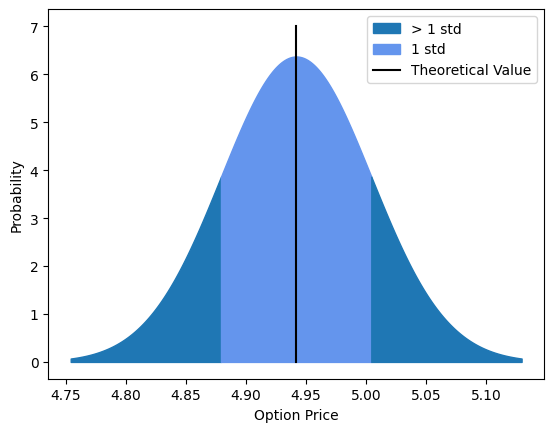

In [45]:
import scipy.stats as stats
import matplotlib.pyplot as plt


x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> 1 std')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 std')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
#plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r', label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()